In [1]:
from typing import Literal, NamedTuple, Callable
from pathlib import Path
import re
from math import log10
from itertools import combinations
from warnings import warn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.classes.digraph import DiGraph
from scipy.spatial import KDTree
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time

from lsst.afw.image import ExposureF
from lsst.daf.butler import Butler, DatasetRef
from lsst.sphgeom import LonLat, Box, Angle, Region
from lsst.rsp import get_tap_service
from lsst.utils.plotting import get_multiband_plot_colors
from lsst.utils.plotting import get_multiband_plot_symbols

filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()

service = get_tap_service("tap")

# DiaSource KD-Tree

With this notebook we take a slight deviation from what we have been worked on so far and build a spatial index of DIASource supporting fast radius and closeness queries. 

## Data loading

### Visits

We will be working with data from the ECDFS sky field. This field is well covered and distant from the galactic planes. It is good for hunting extragalactic transients.

First we query all detector image metadata from the ECDFS sky field, then we filter for all images in the `irg` bands from 10 days.

In [2]:
target_ra, target_dec, radius = 53.160, -28.100, 1.000
selected_bands = ["i", "r", "g"]
t1 = Time("2024-12-01T00:00:00.0", format="isot", scale="tai")
t2 = Time("2024-12-11T00:00:00.0", format="isot", scale="tai")

In [3]:
ccdVisit_astropy = service.search(
    f"SELECT * "
    f"FROM dp1.CcdVisit "
    f"WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {target_ra}, {target_dec}, {radius}))=1"
).to_table()

In [4]:
ccdVisit_df = ccdVisit_astropy.to_pandas()
ccdVisit_df = ccdVisit_df.sort_values("obsStartMJD")
ccdVisit_df = ccdVisit_df[
    (ccdVisit_df["obsStartMJD"] > t1.mjd) & (ccdVisit_df["obsStartMJD"] <= t2.mjd)
]
ccdVisit_df = ccdVisit_df[ccdVisit_df["band"].isin(selected_bands)]
ccdVisit_df = ccdVisit_df.set_index("ccdVisitId")
ccdVisit_df

,astromOffsetMean,astromOffsetStd,band,darkTime,dec,detector,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,...,urcdec,urcra,xSize,ySize,zenithDistance,zeroPoint,visitId,expMidptMJD,expMidpt,obsStartMJD
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
1145204417024,0.011788,0.006040,r,30.4349,-27.832747,0,11.03380,0.307583,1.244190,0.961064,...,-27.934571,53.401083,4071,3999,11.569500,32.031200,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
1145204417029,0.009710,0.004670,r,30.4349,-28.277678,5,11.62860,0.323229,1.247970,0.960937,...,-28.379195,53.082423,4071,3999,11.185300,32.031200,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
1145204417030,0.013386,0.006427,r,30.4349,-27.785922,6,11.60530,0.323764,1.242030,0.962005,...,-27.887086,52.871740,4071,3999,11.132600,32.031799,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
1145204417028,0.007920,0.004600,r,30.4349,-28.043662,4,12.01310,0.335342,1.240090,0.962919,...,-28.145144,53.109517,4071,3999,11.265800,32.032299,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
1145204417026,0.006943,0.003595,r,30.4349,-28.301220,2,11.82520,0.329259,1.245600,0.961104,...,-28.403017,53.348294,4071,3999,11.407000,32.031300,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145279958530,0.023179,0.015518,g,30.4393,-27.809932,2,5.56125,0.293629,0.971333,0.649957,...,-27.804082,53.268005,4071,3999,39.244400,31.968901,2024120900334,60654.249191,2024-12-10T05:58:50.076,60654.249017
1145279958536,0.020684,0.011222,g,30.4393,-28.132990,8,6.02183,0.310483,0.990160,0.652926,...,-28.126629,53.655799,4071,3999,38.832699,31.971399,2024120900334,60654.249191,2024-12-10T05:58:50.076,60654.249017
1145279958529,0.021564,0.012750,g,30.4393,-27.980819,1,5.64783,0.298487,0.968846,0.651000,...,-27.975465,53.084857,4071,3999,39.358101,31.969801,2024120900334,60654.249191,2024-12-10T05:58:50.076,60654.249017


### DiaSources

Then, we get all DIA sources detected over the images in the dataset.

In [5]:
ccdVisit_ids = pd.unique(ccdVisit_df["visitId"])
ccdVisit_ids_str = "(" + ", ".join(map(str, ccdVisit_ids)) + ")"

job = service.submit_job(
    f"SELECT * "
    f"FROM dp1.DiaSource "
    f"WHERE visit IN {ccdVisit_ids_str}"
)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [6]:
diaSource_df = job.fetch_result().to_table().to_pandas()
diaSource_df = diaSource_df.set_index("diaSourceId")
diaSource_df

,apFlux,apFlux_flag,apFlux_flag_apertureTruncated,apFluxErr,band,bboxSize,centroid_flag,coord_dec,coord_ra,dec,...,trailAngle,trailDec,trailFlux,trailLength,trailRa,visit,x,xErr,y,yErr
diaSourceId,,,,,,,,,,,,,,,,,,,,,
600443311873851508,1754.300049,False,False,916.072021,i,25,False,-27.508913,53.414515,-27.508819,...,NaN,NaN,NaN,NaN,NaN,2024120600089,284.363593,NaN,742.628188,NaN
600443311873851487,245.201996,False,False,786.077026,i,11,False,-27.504335,53.422517,-27.504335,...,-105.581594,-27.504318,1690.729980,1.267281,53.422580,2024120600089,235.828919,0.276179,599.600645,0.351804
600443311873851413,24.150900,False,False,857.953979,i,26,False,-27.506117,53.455094,-27.506117,...,77.442870,-27.506119,6298.359863,1.783504,53.455054,2024120600089,387.918816,NaN,102.154050,NaN
600443311873851518,-98.787003,False,False,871.927002,i,28,False,-27.503384,53.397718,-27.503351,...,80.993055,-27.503354,8270.190430,1.641296,53.397713,2024120600089,126.739062,NaN,979.528518,NaN
600438911415615569,-1599.859985,False,False,1014.770020,i,12,False,-27.508913,53.414515,-27.509007,...,NaN,NaN,NaN,NaN,NaN,2024120500071,4000.941305,0.740026,3943.101150,0.400019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600443336438841445,-900.723999,False,False,577.968994,r,14,False,-28.104641,53.572437,-28.104614,...,-5.760851,-28.104653,-2109.459961,1.340927,53.572427,2024120600272,3760.570231,0.576006,3883.108519,0.412210
600443336438841443,-565.924988,False,False,407.337006,r,14,False,-28.101358,53.518276,-28.101358,...,NaN,NaN,NaN,NaN,NaN,2024120600272,4005.723489,0.310771,3059.218120,0.438441
600443336438841439,-1339.520020,False,False,404.859009,r,15,False,-28.111308,53.503747,-28.111285,...,69.051669,-28.111287,-1214.640015,1.961127,53.503773,2024120600272,3881.936145,0.768096,2796.043064,1.122960


### Source filtering

In attempt to remove artifacts, we filter out the DIA sources table of events with problematic flags set. We also remove events with NaN localization entries. These informations will be crucial in the next section.

In [7]:
def verbose(func):
    def msg_wrapper(df: pd.DataFrame, *args, **kwargs):
        len_before, len_before_cols = len(df), len(df.columns)

        df = func(df, *args, *kwargs)
        if (diff := len_before - len(df)):
            print(f"{func.__name__} {'cut' if diff > 0 else 'added'} {abs(diff)} rows ({100 * float(abs(diff / len_before)):.2f} %, originally: {len_before})")
        if (diff := len_before_cols - len(df.columns)):
            print(f"{func.__name__} {'cut' if diff > 0 else 'added'} {abs(diff)} columns (originally: {len_before_cols})")
        return df
    return msg_wrapper


flag_columns = [
    "pixelFlags_cr",
    "pixelFlags_crCenter",
    "centroid_flag",
    "apFlux_flag",
    "isDipole",
    # next flags are from Liu 2024
    "pixelFlags_saturated",
    "pixelFlags_saturatedCenter",
    "pixelFlags_suspect",
    "pixelFlags_suspectCenter",
    "pixelFlags_streak",
    "pixelFlags_streakCenter",
    "pixelFlags_offimage",
    "pixelFlags_bad",
    "psfFlux_flag",
    "shape_flag",
]

def filter_flags(df: pd.DataFrame, flag_columns: list[str]) -> pd.DataFrame:
    for flag in flag_columns:
        def filter_func(df: pd.DataFrame, flag_name: str = flag) -> pd.DataFrame:
            return df[~df[flag_name]]
        
        filter_func.__name__ = f"filter_{flag}"
        df = verbose(filter_func)(df)
    return df

@verbose
def filter_nans(df: pd.DataFrame) -> pd.DataFrame:
    return df.dropna(subset=["ra", "dec", "raErr", "decErr"])


diaSource_df = filter_nans(filter_flags(diaSource_df, flag_columns))

filter_pixelFlags_cr cut 898 rows (0.49 %, originally: 183890)
filter_centroid_flag cut 32469 rows (17.74 %, originally: 182992)
filter_apFlux_flag cut 52 rows (0.03 %, originally: 150523)
filter_isDipole cut 68781 rows (45.71 %, originally: 150471)
filter_pixelFlags_saturated cut 2044 rows (2.50 %, originally: 81690)
filter_pixelFlags_suspect cut 166 rows (0.21 %, originally: 79646)
filter_pixelFlags_streak cut 741 rows (0.93 %, originally: 79480)
filter_shape_flag cut 23801 rows (30.23 %, originally: 78739)
filter_nans cut 41 rows (0.07 %, originally: 54938)


Let's take a look at the DIA source dataset, and in particular to the distribution of the error over the RA and dec.

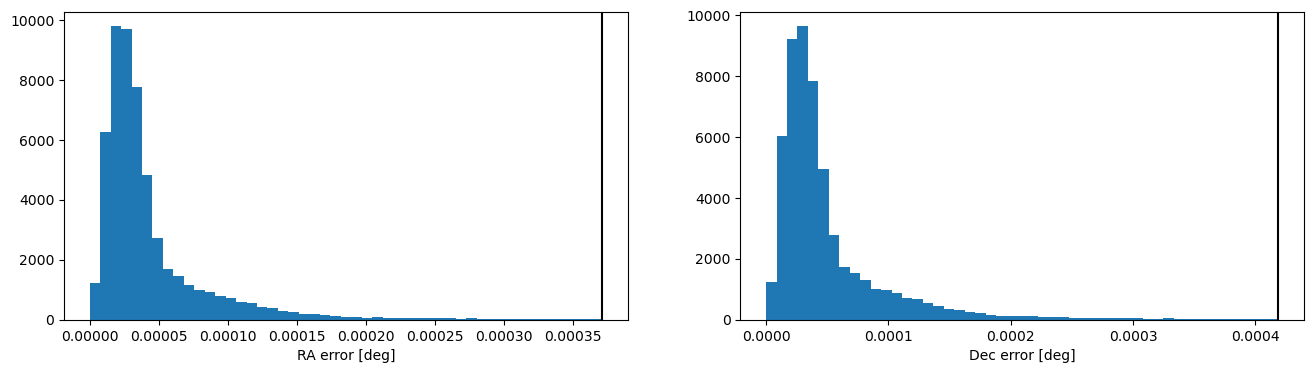

The 99.0-percentile RA error is 1.34 arcsec
The 99.0-percentile dec error is 1.51 arcsec


In [8]:
import matplotlib.pyplot as plt

q = 0.99

fig, axs = plt.subplots(1,2, figsize=(16, 4))
_  = axs[0].hist(diaSource_df["raErr"], bins=np.linspace(0, np.quantile(diaSource_df["raErr"], 0.99), 50))
axs[0].axvline(np.quantile(diaSource_df['raErr'], q), color="k")
axs[0].set_xlabel("RA error [deg]")
_  = axs[1].hist(diaSource_df["decErr"], bins=np.linspace(0, np.quantile(diaSource_df["decErr"], 0.99), 50))
axs[1].axvline(np.quantile(diaSource_df['decErr'], q), color="k")
axs[1].set_xlabel("Dec error [deg]")
plt.show()

print(f"The {100 * q}-percentile RA error is {np.quantile(diaSource_df['raErr'], q) * 60 * 60:.2f} arcsec")
print(f"The {100 * q}-percentile dec error is {np.quantile(diaSource_df['decErr'], q) * 60 * 60:.2f} arcsec")

# Source Matching: KD-Tree Indexing

Now it's time to build the index. We'll use a KD-Tree data structure and implement two main methods:

1. **`search_radius`**: Returns all DiaSources within a circular region centered at given coordinates, using a standard search radius.

2. **`search_close`**: Takes a source (the pivot) as input and finds all other sources whose error boxes overlap with the pivot's error box. This is achieved in two steps. First, we identify candidates around the pivot by searching within a predefined radius (set to the 99th percentile of positional errors, as discussed above).mThen, for each candidate, we check whether its error box overlaps with the pivot's error box, retaining only sources with non-zero overlap.

In [9]:
def sph2xyz(
    lons: np.array, 
    lats: np.array, 
    *,
    units: Literal["radians", "degrees"],
) -> np.array:
    if units == "degrees":
        lons = np.radians(lons)
        lats = np.radians(lats)

    x = (cos_lat_rad := np.cos(lats)) * np.cos(lons)
    y = cos_lat_rad * np.sin(lons)
    z = np.sin(lats)
    return np.column_stack([x, y, z])


def search_radius(
    tree: KDTree,
    center_lon: float, 
    center_lat: float, 
    radius: float,
    *,
    units: Literal["radians", "degrees"]="degrees",
) -> np.array:
    if units == "degrees":
        center_lon = np.radians(center_lon)
        center_lat = np.radians(center_lat)
        radius = np.radians(radius)
        
    # radius = np.sqrt(width ** 2 + height ** 2) / 2  # radians
    if radius > 0.5: 
        warn("Search radius too large for small-angle approximation. Error exceeding 5%.")

    center_xyz = sph2xyz(center_lon, center_lat, units="radians").reshape(-1)
    idxs = tree.query_ball_point(center_xyz, r=radius)
    return idxs


def _map_source2ccdVisit(sources: pd.DataFrame, ccdVisits: pd.DataFrame) -> dict:
   visit_lookup = {
       (row['visitId'], row['detector']): idx 
       for idx, row in ccdVisits.iterrows()
   }
   return {
       idx: visit_lookup.get((row['visit'], row['detector']))
       for idx, row in sources.iterrows()
   }


def _map_v2region(
    ccdVisits: pd.DataFrame,
) -> dict:
    return {
        visit_index: Region.from_ivoa_pos(
            f"POLYGON "
            f"{visit['llcra']} {visit['llcdec']} "
            f"{visit['lrcra']} {visit['lrcdec']} "
            f"{visit['ulcra']} {visit['ulcdec']} "
            f"{visit['urcra']} {visit['urcdec']}"
        )
        for visit_index, visit in ccdVisits.iterrows()
    }


def _map_s2region(
    sources: pd.DataFrame,
    nstd: int=1,
) -> dict:
    return {
        source_index: Box(
            center=LonLat.fromDegrees(source["ra"], source["dec"]), 
            width=Angle.fromDegrees(nstd * source["raErr"]), 
            height=Angle.fromDegrees(nstd * source["decErr"])
        )
        for source_index, source in sources.iterrows()
    }



class SourceTree:
    def __init__(
        self,
        diaSource: pd.DataFrame,
        ccdVisit: pd.DataFrame,
        radius_quantile: float = 0.99,
        nstd: int = 5,
        logger: Callable = lambda _: None,
    ):
        """
        sources and ccdVisits defined according to DP1 schema
        cf. `https://sdm-schemas.lsst.io/dp1.html`
        """
        self.diaSource = diaSource
        self.ccdVisit = ccdVisit
        self.nstd = nstd
        self.radius_quantile = radius_quantile
        self.logger = logger
        
        self.logger("Mapping diaSource to CCD visit..")
        self.map_s2v = _map_source2ccdVisit(diaSource, ccdVisit)
        self.logger("Mapping diaSource to regions..")
        self.map_s2r = _map_s2region(diaSource, nstd)
        self.logger("Building 2D-tree..")
        self.tree = KDTree(sph2xyz(diaSource["ra"], diaSource["dec"], units="degrees"))
        # this quantity will control the number of sources to test for closeness
        # it requires some fine tuning: a value too small will result in missed sources
        # a value too large will slow the algorithm
        self._radius = 2 * nstd * np.sqrt(
            np.quantile(diaSource['raErr'], radius_quantile) ** 2 + 
            np.quantile(diaSource['decErr'], radius_quantile) ** 2
        )

    def _source_time(self, source_index: int) -> float:
        return self.ccdVisit.loc[self.map_s2v[source_index]]["obsStartMJD"]

    def _source_band(self, source_index: int) -> str:
        return self.ccdVisit.loc[self.map_s2v[source_index]]["band"]

    def search_radius(
        self,
        ra: float, 
        dec: float, 
        radius: float,
    ) -> list:
        position_indexes = search_radius(self.tree, ra, dec, radius, units="degrees")
        return sorted(
            self.diaSource.index[position_indexes], 
            key=self._source_time,
        )

    def search_close(
        self,
        source_index: int
    ) -> list:
        ra, dec = self.diaSource.loc[source_index][["ra", "dec"]]
        candidate_ids = self.search_radius(ra, dec, self._radius)
        # always contains the source index itself so we remove it
        candidate_ids.remove(source_index)
        return sorted([*filter(
               lambda idx: self.map_s2r[idx].overlaps(self.map_s2r[source_index]),
                candidate_ids,
            )],
            key=self._source_time,
        )
        
st = SourceTree(diaSource_df, ccdVisit_df, logger = print)

Mapping diaSource to CCD visit..
Mapping diaSource to regions..
Building 2D-tree..


# Tree exploration

Finally we build a collection of DIA source lists, each of these lists should ideally represent an interesting, variable object in the star field. The logic is very raw for the moment but we are able to find some interesting candidates already.

In [14]:
def tree2matches(tree: SourceTree):
    from tqdm import tqdm
    
    seen = set()
    out = []
    for diaSource_index, diaSource in tqdm(
        st.diaSource.loc[sorted(st.diaSource.index, key=st._source_time)].iterrows(), 
        total=len(st.diaSource)
    ):
        if diaSource_index not in seen:
            ms = tree.search_close(diaSource_index)
            if ms:
                out.append(ms)
                seen |= set(ms)
    return out

matches = tree2matches(st)
matches = sorted(matches, key=len)
matches.reverse()

100%|██████████| 54897/54897 [00:48<00:00, 1129.98it/s]


In [15]:
diaSource_ids = matches[0]

In [16]:
node_source = diaSource_ids[0]
node_visit = st.map_s2v[node_source]

print(f"visit, detector = {ccdVisit_df.loc[node_visit]["visitId"]}, {ccdVisit_df.loc[node_visit]["detector"]}")
print(f"x, y = {diaSource_df.loc[node_source]["x"]:.2f}, {diaSource_df.loc[node_source]["y"]:.2f}\n\n")
print(f"ra, dec = {diaSource_df.loc[node_source]["ra"]:.5f} {diaSource_df.loc[node_source]["dec"]:.5f}")
print(f"snr = {diaSource_df.loc[node_source]["snr"]}")
print(f"apFlux = {diaSource_df.loc[node_source]["apFlux"]}")
print(f"mjd time = {st._source_time(node_source)}")

visit, detector = 2024113000169, 8
x, y = 1972.83, 2369.46


ra, dec = 52.83828 -28.27991
snr = 10.185044288635254
apFlux = -1953.9599609375
mjd time = 60645.1183115625


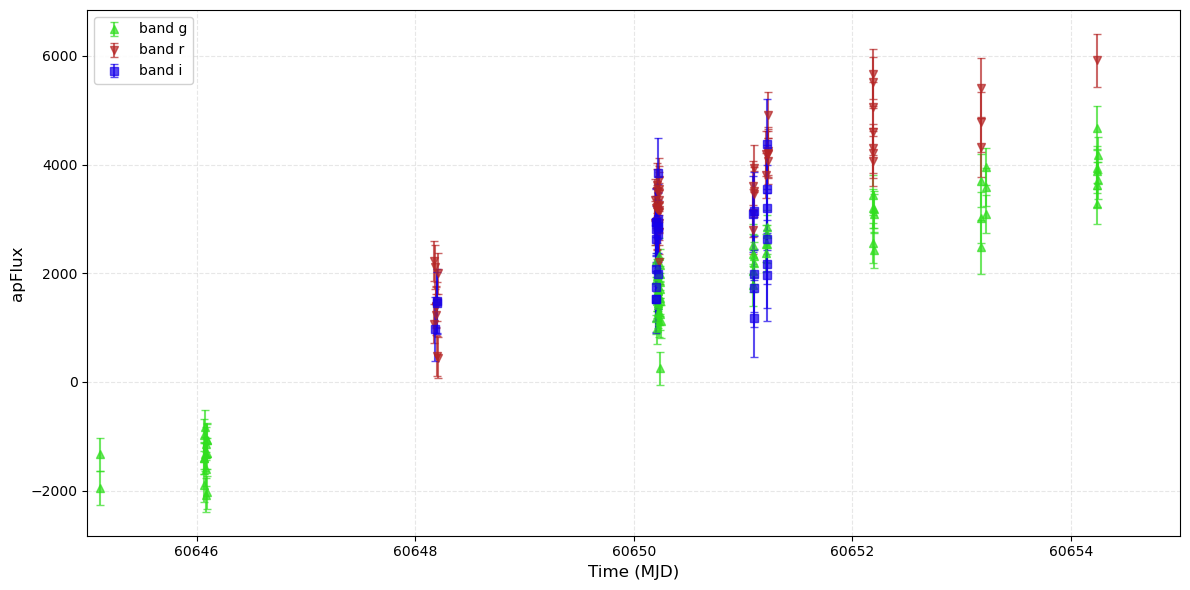

In [17]:
ys = diaSource_df.loc[diaSource_ids]["apFlux"]
yerrs = diaSource_df.loc[diaSource_ids]["apFluxErr"]
bands = [st._source_band(id_) for id_ in diaSource_ids]
xs = [st._source_time(id_) for id_ in diaSource_ids]

fig, ax = plt.subplots(figsize=(12, 6))

for band in filter_names:
    mask = [b == band for b in bands]
    if not any(mask):
        continue
    
    x_band = [x for x, m in zip(xs, mask) if m]
    y_band = [y for y, m in zip(ys, mask) if m]
    yerr_band = [ye for ye, m in zip(yerrs, mask) if m]
    
    ax.errorbar(
        x_band,
        y_band,
        yerr=yerr_band,
        fmt=filter_symbols[band],
        color=filter_colors[band],
        ecolor=filter_colors[band],
        markersize=6,
        capsize=3,
        capthick=1,
        alpha=0.7,
        label=f'band {band}'
    )

ax.set_xlim(left=t1.mjd, right=t2.mjd)
ax.set_xlabel('Time (MJD)', fontsize=12)
ax.set_ylabel('apFlux', fontsize=12)
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()